# Initial Setup

In [1]:
import os
import copy as copy
from math import pi
from collections import defaultdict
import itertools

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn import metrics
import seaborn as sns

from PIL import Image, ImageDraw

from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation, Dropout, Input, Convolution2D, MaxPooling2D, InputLayer, Conv2D, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD

from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook, show
from bokeh.layouts import row
from bokeh.palettes import Category20c
from bokeh.transform import cumsum

from io import BytesIO
import base64
from IPython.core.display import display, HTML

from src.cv.data.raw_data_access import get_partitions_csv, get_features_csv

pd.set_option("display.max_columns", 42)
pd.options.plotting.backend = 'hvplot'
output_notebook()

Using TensorFlow backend.


Loading BokehJS ...

# Utils

In [2]:
# Paths de los datos a utilizar (directorio de las imagenes y csv): CAMBIAR CON LOS QUE CORRESPONDAN

IMAGES_PATH = r"C:\Users\santi\Desktop\TP3"

# IMAGES_PATH = r"C:\Users\agus_\Desktop\ML_Grupo_2\imagenes_tp3_cv"

# Porcentaje de datos con los que me voy a quedar de los conjuntos train, test y validation originales
GLOBAL_FRAC = 0.50

# Datos generales
IMAGE_CHANNELS = 3
IMAGE_HEIGHT = 70
IMAGE_WIDTH = 70

BATCH_SIZE = 32

sgd = SGD(lr=0.01,momentum=0.9,nesterov=True)

In [3]:
def get_train_test_validation(total=False):
    df_images_target = get_features_csv()
    df_images_target.columns = df_images_target.columns.str.lower()
    df_images_target.set_index('image_id', inplace=True)
    
    df_images_target = df_images_target.replace(-1, 0)
    
    df_images_partition = get_partitions_csv()
    df_images_partition.columns = df_images_partition.columns.str.lower()
    df_images_partition.set_index('image_id', inplace=True)
    
    df_images_target["partition"] = df_images_partition["partition"]
    
    df_train = df_images_target[df_images_target.partition == 0].sample(frac=GLOBAL_FRAC, random_state=1)
    df_test = df_images_target[df_images_target.partition == 1].sample(frac=GLOBAL_FRAC, random_state=1)
    df_validation = df_images_target[df_images_target.partition == 2].sample(frac=GLOBAL_FRAC, random_state=1)
    
    if total:
        return pd.concat([df_train, df_test, df_validation])
    else:
        df_train.reset_index(inplace=True)
        df_test.reset_index(inplace=True)
        df_validation.reset_index(inplace=True)
        
        # Necesitamos que el target sea de tipo string porque ImageDataGenerator.flow_from_dataframe asi lo requiere
        df_train['smiling'] = df_train['smiling'].astype(str)
        df_test['smiling'] = df_test['smiling'].astype(str)
        df_validation['smiling'] = df_validation['smiling'].astype(str)

        return df_train[['image_id', "smiling"]], df_test[['image_id', "smiling"]], df_validation[['image_id', "smiling"]]

In [4]:
def make_data_volume(df, part, tot=False):
    if tot:
        _df = df.copy()
    else:
        _df = df[df.partition == part].copy()
    
    _df.drop('partition', axis=1, inplace=True)
    _df = _df.apply(pd.Series.value_counts)
    _df.rename(index={0: 'No', 1: 'Yes'}, inplace=True)
    return _df.T

In [5]:
def get_generator(df, height=IMAGE_HEIGHT, width=IMAGE_WIDTH, batch_size=BATCH_SIZE):
    data_gen = ImageDataGenerator(
        rescale=1./255,
    )
    generator = data_gen.flow_from_dataframe(
        # Pandas DataFrame which contains the filenames and classes or numeric data to be treated as target values.
        dataframe=df,
        # Path to the folder which contains all the images.
        directory=IMAGES_PATH,
        # The column in the dataframe that has the filenames of the images.
        x_col='image_id',
        # Column in dataframe that has the target data.
        y_col='smiling',
        # Mode for yielding the targets.
        class_mode="binary",
        # Size of the batches of data.
        batch_size=BATCH_SIZE,
        # Whether to shuffle the data.
        shuffle=False,
        # Random seed for shuffling and transformations.
        seed=1,
        # The dimensions to which all images found will be resized.
        target_size=(height,width)
    )
    return generator

In [6]:
def evaluate_model(model, generators, title='',cnn=False, show_cm=True):
    if title:
        display(title)
    final_metrics = defaultdict(list)
    set_names = []
    if show_cm:
        fig, axis = plt.subplots(1, len(generators), sharey=True, figsize=(15, 3))
        
    if cnn:
            outputs_train = y_train
            predictions_train = cnn_model.predict(X_train)
            outputs_test = y_test
            predictions_test = cnn_model.predict(X_test)
    else:
        i = -1
        for set_name, set_generator in generators:
            set_names.append(set_name)
            i = i+1
            
            y = set_generator.classes
            steps = len(y) // BATCH_SIZE + 1
            prediction = model.predict_generator(set_generator, steps, workers=4, verbose=1)
            pred = prediction.round()
            y_pred = list(map(int,list(itertools.chain.from_iterable(pred))))
            
            final_metrics['Accuracy'].append(metrics.accuracy_score(y, y_pred))
            final_metrics['Precision'].append(metrics.precision_score(y, y_pred))
            final_metrics['Recall'].append(metrics.recall_score(y, y_pred))
            final_metrics['F1'].append(metrics.f1_score(y, y_pred))
            
            if show_cm:
                ax = axis[i]
                sns.heatmap(metrics.confusion_matrix(y, y_pred), ax=ax, cmap='Greens', annot=True, fmt='.0f', cbar=False)

                ax.set_title(set_name)
                ax.xaxis.set_ticklabels(['No sonríe', 'Sonríe'])
                ax.yaxis.set_ticklabels(['No sonríe', 'Sonríe'])
                ax.set_xlabel('Predicted class')
                ax.set_ylabel('True class')
            
    display(pd.DataFrame(final_metrics, index=tuple(set_names)))
    if show_cm:
        plt.tight_layout()
        plt.show()

In [7]:
def plot_learning_curve(model_history):
    axes = plt.gca() 
    plt.plot(model_history.history['accuracy'], label='train')
    plt.plot(model_history.history['val_accuracy'], label='test')
    plt.title('Evolución de Accuracy durante el entrenamiento')
    plt.ylabel('Accuracy')
    plt.xlabel('Época')
    plt.legend(loc='lower right')
    axes.set_ylim([0,1])
    plt.show()

In [8]:
def img_to_display(filename):
    i = Image.open(os.path.join(IMAGES_PATH,filename))
    
    with BytesIO() as buffer:
        i.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

In [9]:
def get_predict_samples(df, model, quantity=16, random_state=1):
    # Busco ejemplos random del dataset
    df_sample = df.sample(quantity, random_state=random_state)
    
    # Obtengo el generador
    df_sample_generator = get_generator(df_sample)
    
    # Reseteo generador
    df_sample_generator.reset()
    
    # Predigo
    y = df_sample_generator.classes
    steps = len(y) // BATCH_SIZE + 1
    prediction = model.predict_generator(df_sample_generator, steps, workers=4)
    pred = prediction.round()
    prediction_class = list(map(int,list(itertools.chain.from_iterable(pred))))
    
    # Reseteo el indice para que vaya del 0 al quantity
    df_sample.reset_index(inplace=True)
    
    desc = {0: 'Not Smiling',
        1: 'Smiling'}
    display_html = '''
    '''
    for i in range(quantity):

        filename = df_sample.iloc[i:i+1]['image_id'].values[0]
        
        if(i%2 == 0):
            zone='left'
        else:
            zone='right'
        
        display_html += '''
        <div style="border: 2px solid #D8D8D8; float:{}; width: 45%;" >
            <img src="data:image/jpeg;base64,{}" style="float: left; padding: 5px 5px 5px 5px">
            <div style="padding: 10px 0px 0px 15px; overflow: auto;">
                <h2>{}</h2>
                <p style="margin-top: 5px; font-size: 16px">Probability: {}</p>
                <p style="margin-top: 1px; font-size: 16px">Real Target: {}</p>
            </div>
        </div>
        '''.format(zone
                   , img_to_display(filename)
                   , desc[prediction_class[i]]
                   , "{0:.2f}%".format(round(prediction[i][0]*100,2))
                   , desc[y[i]]
                   )

    display(HTML(display_html))

# Read data

**Lectura del set de datos con el que se trabajará**

In [10]:
p = round(GLOBAL_FRAC*100, 2)
print("Debido a la cantidad elevada de imagenes, a las limitaciones de hardware y al reducido tiempo para las pruebas,")
print(f"se trabajará con una fracción del dataset original. Este corresponde al {p}% del mismo.")

Debido a la cantidad elevada de imagenes, a las limitaciones de hardware y al reducido tiempo para las pruebas,
se trabajará con una fracción del dataset original. Este corresponde al 50.0% del mismo.


In [26]:
# Se obtienen los datos que se usarán en el trabajo (total=True)
df_data = get_train_test_validation(total=True)

**División del set de datos**

Se obtienen dos arrays para cada set de datos (train, test, validation):

* X_images: array de numpy que representa a cada imagen.
* X_target: array que cuenta con el target (si sonríe o no) para cada una de las imagenes anteriores.

*Anotación: "X" hace referencia al set correspondiente (train, test o validation)*

In [12]:
# Se obtienen los datos corresponidentes a los conjuntos de train, test y validation
df_train, df_test, df_validation = get_train_test_validation()

# Ejemplos de las imágenes

In [13]:
X, y = get_generator(pd.concat([df_train, df_test, df_validation]),height=218, width=178).next()

Found 101300 validated image filenames belonging to 2 classes.


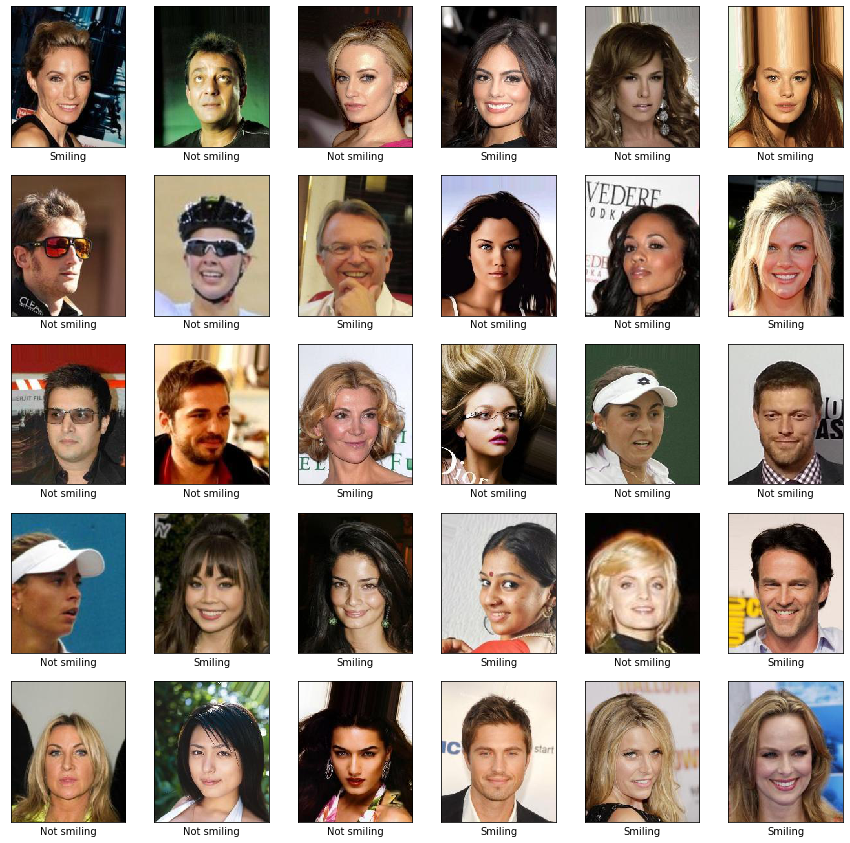

In [14]:
desc = {0: 'Not smiling',
        1: 'Smiling'}

plt.figure(figsize=(15,15))
for i in range(5):
    for j in range(6):
        plt.subplot(5, 6, (i*6)+j+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        image = copy.copy(X[(i*6)+j])
        plt.imshow(image.reshape(218, 178, IMAGE_CHANNELS), cmap=plt.cm.binary)
        plt.xlabel(desc[y[(i*6)+j]])

# Exploratory data analysis

## Target distribution

In [15]:
vc = df_data.smiling.value_counts().to_frame()
vc.rename(columns={'smiling': 'value'}, inplace=True)

mask = vc.index == 0

vc.loc[::, 'target'] = 'Sonríe (1)'
vc.loc[mask, 'target'] = 'No sonríe (0)'

x = {
    'No sonríe (0)': vc[vc.index == 0].value.values[0],
    'Sonrie (1)': vc[vc.index == 1].value.values[0]
}

vc['angle'] = vc['value'] / vc['value'].sum() * 2 * pi
vc['color'] = ['#3182bd', '#e6550d']

p = figure(plot_height=350, title="Distribución del target", toolbar_location=None,
           tools="hover", tooltips="@target: @value", x_range=(-0.5, 1.0))

p.wedge(x=0, y=1, radius=0.4,
        start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),
        line_color="white", fill_color='color', legend_field='target', source=vc)

p.axis.axis_label=None
p.axis.visible=False
p.grid.grid_line_color = None

show(p)

In [16]:
p = round((len(df_data[df_data.smiling == 1])/len(df_data))*100, 2)
print(f"La cantidad de personas que están sonriendo representan el {p}% del conjunto de datos.")
print(f"La cantidad de personas que no están sonriendo representan el {100-p}% del conjunto de datos.")

La cantidad de personas que están sonriendo representan el 48.27% del conjunto de datos.
La cantidad de personas que no están sonriendo representan el 51.73% del conjunto de datos.


Podemos observar que el target se encuentra casi perfectamente balanceado.

## Data volume

In [17]:
print("Cantidad total de imágenes:", len(df_data), "\n")
print("Cantidad en train:", len(df_train))
print("Cantidad en test:", len(df_test))
print("Cantidad en validation:", len(df_validation))

Cantidad total de imágenes: 101300 

Cantidad en train: 81385
Cantidad en test: 9934
Cantidad en validation: 9981


**Total data volumes**

Cantidad de datos con respecto a los casos positivos y negativos de cada variable del dataframe total.

In [18]:
make_data_volume(df_data, 0, tot=True)

,No,Yes
5_o_clock_shadow,90106,11194
arched_eyebrows,74064,27236
attractive,49299,52001
bags_under_eyes,80612,20688
bald,99085,2215
bangs,85975,15325
big_lips,77012,24288
big_nose,77457,23843
black_hair,76929,24371
blond_hair,86298,15002


**Train volumes**

Cantidad de datos con respecto a los casos positivos y negativos de cada variable del dataframe de train.

In [19]:
make_data_volume(df_data, 0)

,No,Yes
5_o_clock_shadow,72362,9023
arched_eyebrows,59563,21822
attractive,39473,41912
bags_under_eyes,64784,16601
bald,79605,1780
bangs,69100,12285
big_lips,61867,19518
big_nose,62190,19195
black_hair,61761,19624
blond_hair,69285,12100


**Test volumes**

Cantidad de datos con respecto a los casos positivos y negativos de cada variable del dataframe de test.

In [20]:
make_data_volume(df_data, 1)

,No,Yes
5_o_clock_shadow,8766,1168
arched_eyebrows,7386,2548
attractive,4760,5174
bags_under_eyes,7879,2055
bald,9725,209
bangs,8459,1475
big_lips,8434,1500
big_nose,7433,2501
black_hair,7862,2072
blond_hair,8394,1540


**Validation volumes**

Cantidad de datos con respecto a los casos positivos y negativos de cada variable del dataframe de validation.

In [21]:
make_data_volume(df_data, 2)

,No,Yes
5_o_clock_shadow,8978,1003
arched_eyebrows,7115,2866
attractive,5066,4915
bags_under_eyes,7949,2032
bald,9755,226
bangs,8416,1565
big_lips,6711,3270
big_nose,7834,2147
black_hair,7306,2675
blond_hair,8619,1362


## Images type and structure

# Experiments

## Multi Layer Perceptron (MLP)

### Image Generator

In [22]:
# Obtenemos el gerador para cada conjunto de datos
MLP_train_generator = get_generator(df_train)
MLP_test_generator = get_generator(df_test)
MLP_validation_generator = get_generator(df_validation)

Found 81385 validated image filenames belonging to 2 classes.
Found 9934 validated image filenames belonging to 2 classes.
Found 9981 validated image filenames belonging to 2 classes.


### Models

Para que esta red pueda entrenar necesitaremos pasarle una lista de arrays donde cada array represente una imagen. Para ello, transformamos la estructura tridimensional del array de numpy (obtenido al leer las imagenes) en unidimencional por medio de una primer capa (Flatten).

Como función de activacion optamos por "relu" en las capas ocultas, y por "sigmoid" en la capa de salida. Esto ultimo debido a que contamos con una unica salida (al ser una clasificacion binaria) que nos indicará la probabilidad de que un imput (imagen) este sonriendo (smiling = 1). Como optimizador nos decidimos por "adam" y como funcion de perdida "binary_crossentropy" por lo mencionado anteriormente.

En cuanto a la métrica, nos basaremos en "accuracy" debido a que, como pudimos ver en la distribución del target, el dataset se encuentra balanceado.

En cuanto a las épocas usadas, decidimos empezar por 5 para analizar una primera tendencia con cada configuracion y luego aumentarlo si es necesario.

#### 1° experiment

In [23]:
MLP_model_1 = Sequential([
    Flatten(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)),
    
    Dense(64, activation='relu'),
    
    Dense(32, activation='relu'),
    Dropout(0.1),
    
    Dense(16, activation='relu'),
    Dropout(0.1),
    
    Dense(8, activation='relu'),
    Dropout(0.1),
    
    Dense(1, activation='sigmoid')
])

MLP_model_1.compile(
    optimizer="adam",
    loss='binary_crossentropy',
    metrics=['accuracy',],
)

In [23]:
MLP_train_generator.reset()
MLP_test_generator.reset()

MLP_history_1 = MLP_model_1.fit_generator(MLP_train_generator, 
              epochs=5,
              workers=4,
              validation_data=MLP_test_generator
)

Epoch 1/3
2544/2544 [==============================] - 247s 97ms/step - loss: 0.4940 - accuracy: 0.7322 - val_loss: 0.2464 - val_accuracy: 0.8815
Epoch 2/3
2544/2544 [==============================] - 75s 30ms/step - loss: 0.3188 - accuracy: 0.8651 - val_loss: 0.2351 - val_accuracy: 0.8721
Epoch 3/3
2544/2544 [==============================] - 70s 27ms/step - loss: 0.3006 - accuracy: 0.8727 - val_loss: 0.1794 - val_accuracy: 0.8873


312/312 [==============================] - 24s 78ms/step


,Accuracy,Precision,Recall,F1
Train,0.888432,0.867108,0.906797,0.886509
Test,0.887256,0.864714,0.907760,0.885714
Validation,0.884280,0.870342,0.904211,0.886953


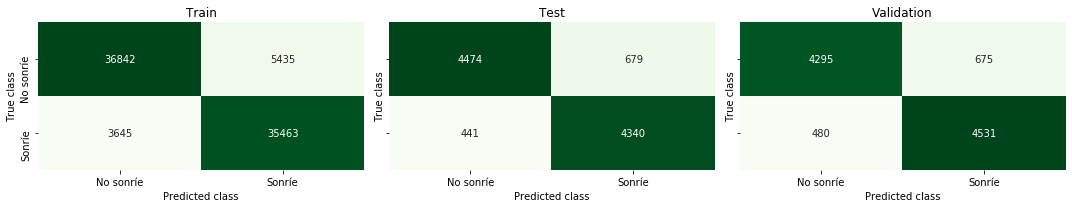

In [25]:
MLP_train_generator.reset()
MLP_test_generator.reset()
MLP_validation_generator.reset()

generators = [("Train", MLP_train_generator),
              ("Test", MLP_test_generator),
              ("Validation", MLP_validation_generator)]

evaluate_model(MLP_model_1, generators)

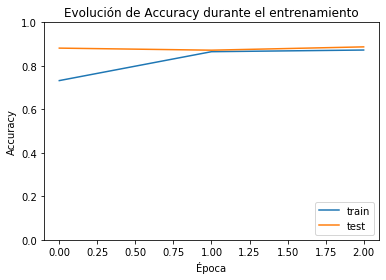

In [28]:
plot_learning_curve(MLP_history_1)

#### 2° experiment

Luego de la configuración anterior, decidimos hacer otro experimento, modificando el optimizador a SGD, pero manteniendo el resto de los hiperparametros.

In [28]:
MLP_model_2 = Sequential([
    Flatten(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)),
    
    Dense(64, activation='relu'),
    
    Dense(32, activation='relu'),
    Dropout(0.1),
    
    Dense(16, activation='relu'),
    Dropout(0.1),
    
    Dense(8, activation='relu'),
    Dropout(0.1),
    
    Dense(1, activation='sigmoid')
])

MLP_model_2.compile(
    optimizer=sgd,
    loss='binary_crossentropy',
    metrics=['accuracy',],
)

In [29]:
MLP_train_generator.reset()
MLP_test_generator.reset()

MLP_history_2 = MLP_model_2.fit(MLP_train_generator, 
              epochs=5,
              workers=4, 
              validation_data=MLP_test_generator
)

Epoch 1/5
2544/2544 [==============================] - 62s 24ms/step - loss: 0.4180 - accuracy: 0.7956 - val_loss: 0.2045 - val_accuracy: 0.8847
Epoch 2/5
1901/2544 [=====================>........] - ETA: 15s - loss: 0.3002 - accuracy: 0.8741

KeyboardInterrupt: 

156/156 [==============================] - 10s 62ms/step


,Accuracy,Precision,Recall,F1
Train,0.502525,0.478813,0.398435,0.434942
Test,0.507751,0.486365,0.406609,0.442925
Validation,0.493938,0.495247,0.415885,0.452110


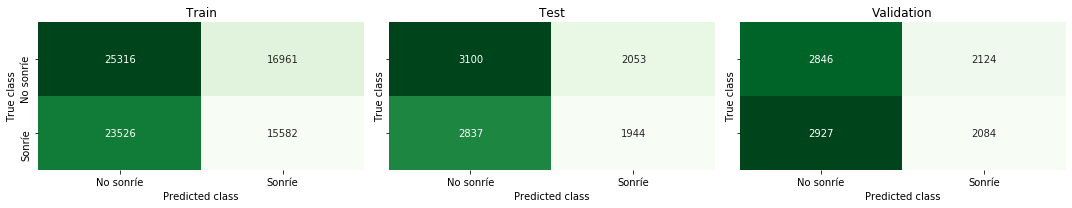

In [39]:
MLP_train_generator.reset()
MLP_test_generator.reset()
MLP_validation_generator.reset()

generators = [("Train", MLP_train_generator),
              ("Test", MLP_test_generator),
              ("Validation", MLP_validation_generator)]

evaluate_model(model=MLP_model_2, generators=generators)

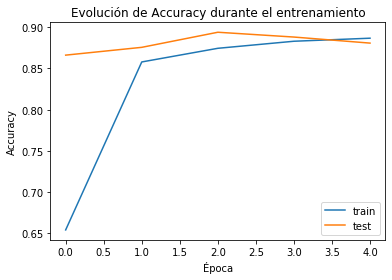

In [38]:
plot_learning_curve(MLP_history_2)

#### 3° experiment

Decidimos probar cambiar la funcion de activacion de las capas ocultas a "tanh" para ver si las métricas aumentaban.

In [31]:
MLP_model_3 = Sequential([
    Flatten(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)),
    
    Dense(64, activation='tanh'),
    
    Dense(32, activation='tanh'),
    Dropout(0.1),
    
    Dense(16, activation='tanh'),
    Dropout(0.1),
    
    Dense(8, activation='tanh'),
    Dropout(0.1),
    
    Dense(1, activation='sigmoid')
])

MLP_model_3.compile(
    optimizer="adam",
    loss='binary_crossentropy',
    metrics=['accuracy',],
)

In [32]:
MLP_train_generator.reset()
MLP_test_generator.reset()

MLP_history_3 = MLP_model_3.fit(MLP_train_generator, 
              epochs=5,
              workers=4, 
              validation_data=MLP_test_generator
)

Epoch 1/5
 607/2544 [======>.......................] - ETA: 47s - loss: 0.7070 - accuracy: 0.5041- ETA: 

KeyboardInterrupt: 

In [ ]:
MLP_train_generator.reset()
MLP_test_generator.reset()
MLP_validation_generator.reset()

generators = [("Train", MLP_train_generator),
              ("Test", MLP_test_generator),
              ("Validation", MLP_validation_generator)]

evaluate_model(model=MLP_model_3, generators=generators)

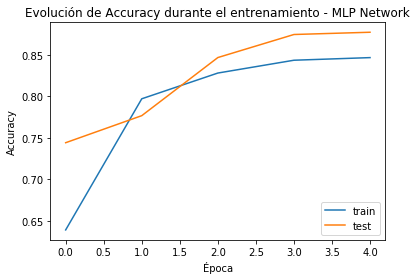

In [93]:
plot_learning_curve(MLP_history_3)

Al ver que los resultados empeoraron, decidimos optar por cambiar el optimizador a SGD.

#### 4° experiment

In [26]:
MLP_model_4 = Sequential([
    Flatten(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)),
    
    Dense(64, activation='tanh'),
    
    Dense(32, activation='tanh'),
    Dropout(0.1),
    
    Dense(16, activation='tanh'),
    Dropout(0.1),
    
    Dense(8, activation='tanh'),
    Dropout(0.1),
    
    Dense(1, activation='sigmoid')
])

MLP_model_4.compile(
    optimizer=sgd,
    loss='binary_crossentropy',
    metrics=['accuracy',],
)

In [27]:
MLP_train_generator.reset()
MLP_test_generator.reset()

MLP_history_4 = MLP_model_4.fit(MLP_train_generator, 
              epochs=5,
              workers=4, 
              validation_data=MLP_test_generator
)

Epoch 1/5
1272/1272 [==============================] - 53s 41ms/step - loss: 0.5632 - accuracy: 0.7115 - val_loss: 0.6610 - val_accuracy: 0.7043
Epoch 2/5
1272/1272 [==============================] - 54s 43ms/step - loss: 0.6049 - accuracy: 0.6688 - val_loss: 0.7940 - val_accuracy: 0.6828
Epoch 3/5
1272/1272 [==============================] - 53s 42ms/step - loss: 0.5086 - accuracy: 0.7706 - val_loss: 0.3698 - val_accuracy: 0.7954
Epoch 4/5
1272/1272 [==============================] - 59s 46ms/step - loss: 0.4325 - accuracy: 0.8354 - val_loss: 1.0881 - val_accuracy: 0.6935
Epoch 5/5
1272/1272 [==============================] - 54s 42ms/step - loss: 0.3861 - accuracy: 0.8522 - val_loss: 0.1967 - val_accuracy: 0.8742


In [ ]:
MLP_train_generator.reset()
MLP_test_generator.reset()
MLP_validation_generator.reset()

generators = [("Train", MLP_train_generator),
              ("Test", MLP_test_generator),
              ("Validation", MLP_validation_generator)]

evaluate_model(model=MLP_model_4, generators=generators)

In [ ]:
plot_learning_curve(MLP_history_4)

#### 5° experiment

In [33]:
MLP_model = Sequential([
    Flatten(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)),
    
    Dense(4096, activation='tanh'),
    
    Dense(128, activation='tanh'),
    Dropout(0.1),
    
    Dense(16, activation='tanh'),
    Dropout(0.1),
    
    Dense(1, activation='sigmoid')
])

MLP_model.compile(
    optimizer=sgd,
    loss='binary_crossentropy',
    metrics=['accuracy',],
)

In [34]:
MLP_model.fit(MLP_train_generator, 
              epochs=5,
              workers=4, 
              validation_data=MLP_test_generator
)

Epoch 1/5
2544/2544 [==============================] - 1120s 440ms/step - loss: 0.4121 - accuracy: 0.8040 - val_loss: 0.2650 - val_accuracy: 0.8640
Epoch 2/5
 961/2544 [==========>...................] - ETA: 11:23 - loss: 0.3124 - accuracy: 0.8664

KeyboardInterrupt: 

### Prediction examples with validation

Algunos ejemplos de las predicciones realizadas por el "mejor modelo" de MLP, usando los datos de validation, son los siguientes. De cada uno se muestra la clase predicha, la probabilidad arrojada y la clase real. En cuianto a la probabilidad de que la persona sonría es necesario aclarar que si es mayor al 50% corresponde a *Smiling* y si es menor que ese porcentaje a *Not Smiling*.

Found 16 validated image filenames belonging to 2 classes.



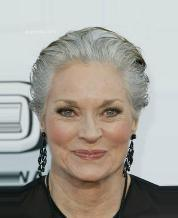
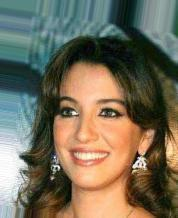
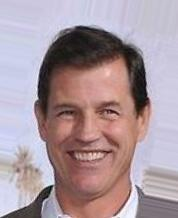
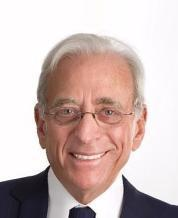
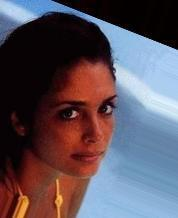
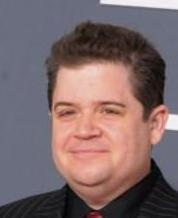
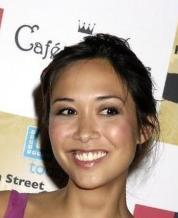
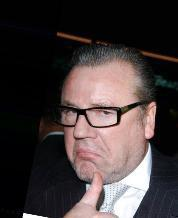
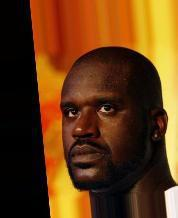
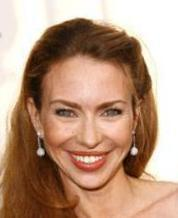
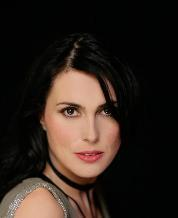
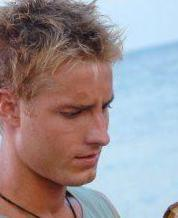
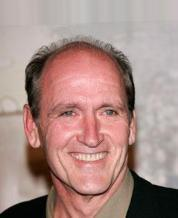
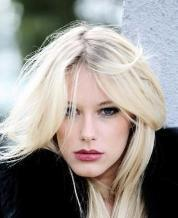
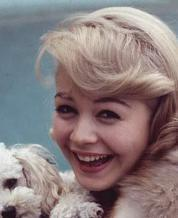
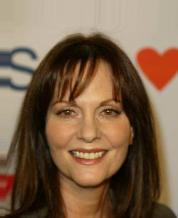

In [324]:
get_predict_samples(df_validation,MLP_model_1)

# CNN

In [325]:
# Obtenemos el gerador para cada conjunto de datos
CNN_train_generator = get_generator(df_train)
CNN_test_generator = get_generator(df_test)
CNN_validation_generator = get_generator(df_validation)

Found 81385 validated image filenames belonging to 2 classes.
Found 9934 validated image filenames belonging to 2 classes.
Found 9981 validated image filenames belonging to 2 classes.


In [338]:
#Definición de la arquitectura de la red convolucional
CNN_model_1 = Sequential([
    Conv2D(10,kernel_size=(3,3),activation='relu',input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)),
    Conv2D(5,kernel_size=(3,3),activation='relu'),
    Dropout(0.1),
    Conv2D(2,kernel_size=(3,3),activation='relu'),
    Dropout(0.1),
    Flatten(),
    Dense(10,activation='relu'),
    Dropout(0.1),
    Dense(5,activation='relu'),
    Dropout(0.1),
    Dense(1,activation='sigmoid')
])

In [339]:
CNN_model_1.compile(
    optimizer=sgd,
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

In [340]:
CNN_train_generator.reset()
CNN_test_generator.reset()

CNN_history_1 = CNN_model_1.fit(CNN_train_generator, 
              epochs=5,
              workers=4, 
              validation_data=CNN_test_generator
)

Epoch 1/5
2544/2544 [==============================] - 407s 160ms/step - loss: 0.3561 - accuracy: 0.8454 - val_loss: 0.1772 - val_accuracy: 0.8883
Epoch 2/5
2544/2544 [==============================] - 357s 140ms/step - loss: 0.2702 - accuracy: 0.8863 - val_loss: 0.2350 - val_accuracy: 0.8997
Epoch 3/5
2544/2544 [==============================] - 357s 140ms/step - loss: 0.2484 - accuracy: 0.8979 - val_loss: 0.1702 - val_accuracy: 0.9037
Epoch 4/5
2544/2544 [==============================] - 361s 142ms/step - loss: 0.2366 - accuracy: 0.9037 - val_loss: 0.1669 - val_accuracy: 0.9089
Epoch 5/5
2544/2544 [==============================] - 366s 144ms/step - loss: 0.2274 - accuracy: 0.9062 - val_loss: 0.1564 - val_accuracy: 0.9084


312/312 [==============================] - 32s 101ms/step


,Accuracy,Precision,Recall,F1
Train,0.927222,0.923332,0.925386,0.924358
Test,0.908395,0.904832,0.904832,0.904832
Validation,0.902314,0.901672,0.904011,0.902840


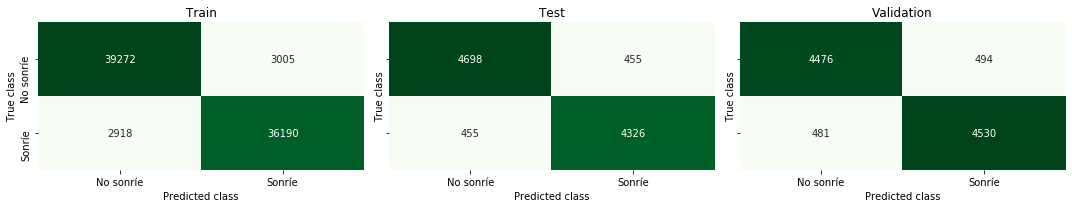

In [341]:
CNN_train_generator.reset()
CNN_test_generator.reset()
CNN_validation_generator.reset()

generators = [("Train", CNN_train_generator),
              ("Test", CNN_test_generator),
              ("Validation", CNN_validation_generator)]

evaluate_model(CNN_model_1, generators)

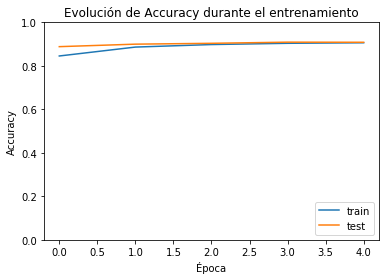

In [342]:
plot_learning_curve(CNN_history_1)

### Prediction examples with validation

Algunos ejemplos de las predicciones realizadas por el "mejor modelo" de CNN, usando los datos de validation, son los siguientes. Al igual de como se hizo para MLP, se muestra la clase predicha, la probabilidad arrojada y la clase real para cada imagen de entrada.

Found 16 validated image filenames belonging to 2 classes.



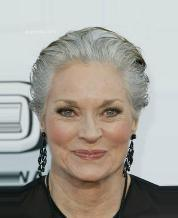
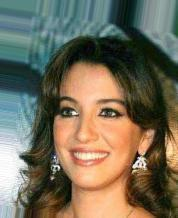
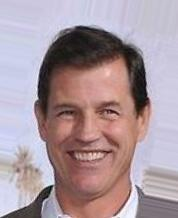
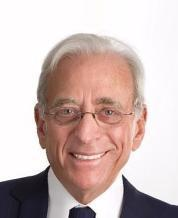
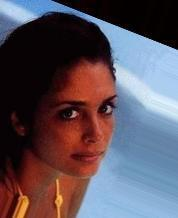
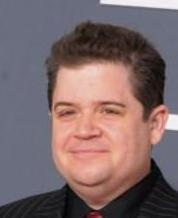
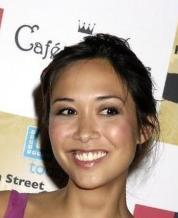
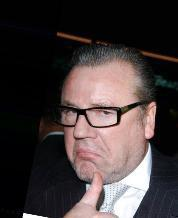
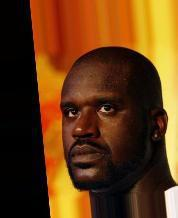
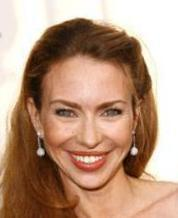
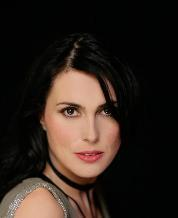
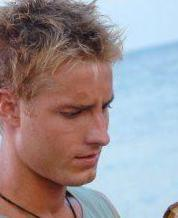
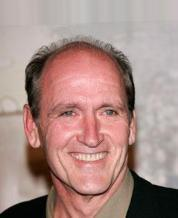
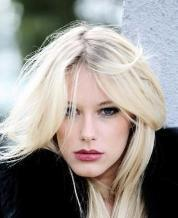
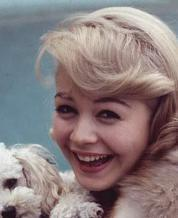
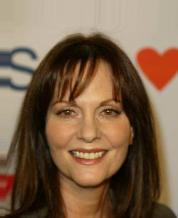

In [343]:
get_predict_samples(df_validation,CNN_model_1)